In [1]:
# data exploration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

%matplotlib inline

In [3]:
# import all 3 datasets for Seattle Airbnb (listings, reviews, calendar) and identify useful information that can be used for the model
# start with reviews file, to check data structure

reviews = pd.read_csv('seattle/reviews.csv')
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [4]:
# check listings data, check columns and identify what needs to be removed
listings = pd.read_csv('seattle/listings.csv')
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [5]:
listings.price.head()

0     $85.00
1    $150.00
2    $975.00
3    $100.00
4    $450.00
Name: price, dtype: object

In [6]:
# check calendar data
calendar = pd.read_csv('seattle/calendar.csv')
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


Goal is to predict property price based on reviews, which in turn can describe how reviews affects the price of the property
Identify frequency of price change on listings

In [7]:
# check on shapes of datasets

print("Listings shape: ",listings.shape)
print("Reviews shape: ", reviews.shape)
print("Calendar shape: ",calendar.shape)

# subset of calendar when a listing is unavailable for later reference

unavailable = calendar[calendar.available == 'f']
print("Unavailable Calendar shape: ", unavailable.shape)

Listings shape:  (3818, 92)
Reviews shape:  (84849, 6)
Calendar shape:  (1393570, 4)
Unavailable Calendar shape:  (459028, 4)


In [11]:
# frequency of price change
# identify all new prices

available_calendar = calendar[calendar.available == 't']

all_prices = available_calendar.groupby('listing_id')['price'].nunique()
unique_prices = all_prices.to_frame()
changed_count = unique_prices[unique_prices['price'] > 1].shape[0]

# print values
print("Count of unique prices: {}".format(changed_count))
print("Total available listings: {}".format(unique_prices.shape[0]))
print("Change Percentage: {}".format(changed_count/unique_prices.shape[0]))

Count of unique prices: 2115
Total available listings: 3723
Change Percentage: 0.5680902497985496


Listings changed > 20x:  (287, 1)


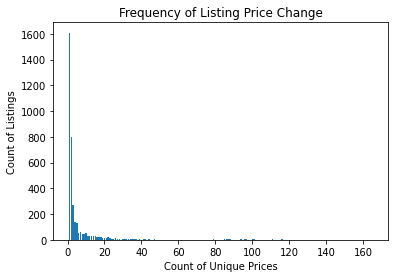

In [14]:
# get value of price count per listing
calendar_unique_data = pd.value_counts(all_prices)

# visualize via chart
plt.bar(calendar_unique_data.index, calendar_unique_data.values)
plt.title("Frequency of Listing Price Change")
plt.xlabel("Count of Unique Prices")
plt.ylabel("Count of Listings")
plt.xticks(np.arange(0, 180, step=20));

# print value of listings that changed prices > 20 times
print("Listings changed > 20x: ", unique_prices[unique_prices['price'] > 20].shape)

Identify if count of reviews affects the price of listing

In [15]:
# merge calendar data (price) and reviews

reviews.drop(columns=["id", "reviewer_id", "reviewer_name", "date"], inplace=True)
reviews.shape

(84849, 2)

In [16]:
# clean up data on prices column
prices = available_calendar.drop(columns=['available', 'date'])
prices.drop_duplicates(subset='price', keep="first", inplace=True)
prices.head()

,listing_id,price
0,241032,$85.00
365,953595,$125.00
452,953595,$154.00
453,953595,$164.00
454,953595,$165.00


In [20]:
# merge reviews and prices updated datasets
reviews_prices = pd.merge(reviews, prices, on="listing_id", how="outer")
print(reviews_prices.tail())

# print shape of dataframe for reference
print("Reviews/Prices shape: ", reviews_prices.shape)

       listing_id comments    price
99849     9922335      NaN  $552.00
99850     9922335      NaN  $460.00
99851     9976135      NaN   $28.00
99852     9444769      NaN  $283.00
99853     9609152      NaN  $628.00
Reviews/Prices shape:  (99854, 3)


In [21]:
# remove listings that does not contain prices
# remove NaN
reviews_prices.dropna(axis=0, how='any', subset={'price'}, inplace=True)
print(reviews_prices.head())
print("Reviews/Prices shape: ", reviews_prices.shape)

      listing_id                                           comments    price
2552     7207641  Joe and Anna are very friendly. They made us f...  $348.00
2553     7207641  Listing was accurate, host even left neighborh...  $348.00
2554     7207641  Great house in a great neighborhood! Everythin...  $348.00
2555     7207641  Great house! Top notch location and appliances...  $348.00
2556     7207641  Very clean and organized.  The hosts provided ...  $348.00
Reviews/Prices shape:  (17591, 3)


In [22]:
# create a count column for count of reviews for each listing
reviews_prices["count"] = reviews_prices.groupby('listing_id')['listing_id'].transform("count")
reviews_prices.head()

,listing_id,comments,price,count
2552,7207641,Joe and Anna are very friendly. They made us f...,$348.00,5
2553,7207641,"Listing was accurate, host even left neighborh...",$348.00,5
2554,7207641,Great house in a great neighborhood! Everythin...,$348.00,5
2555,7207641,Great house! Top notch location and appliances...,$348.00,5
2556,7207641,Very clean and organized. The hosts provided ...,$348.00,5


In [25]:
# check for datatype of price to make sure it is int
print("price data type: ", type(reviews_prices['price'].iloc[0]))

# change to int
reviews_prices['price'] = pd.to_numeric(reviews_prices['price'].map(lambda x: x.strip('$').replace(',','')))

# remove duplicates
reviews_prices_unique = reviews_prices.drop_duplicates(subset='listing_id')

price data type:  <class 'str'>


Based on the graph, there is no direct correlation between review count and price


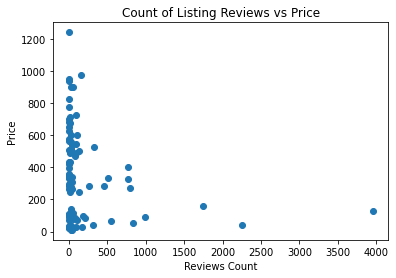

In [28]:
# plot review counts
plt.scatter(reviews_prices_unique['count'], reviews_prices_unique['price'])
plt.title("Count of Listing Reviews vs Price")
plt.xlabel("Reviews Count")
plt.ylabel("Price");

print("Based on the graph, there is no direct correlation between review count and price")

Price prediction based on reviews
- utilize NLP tokenization

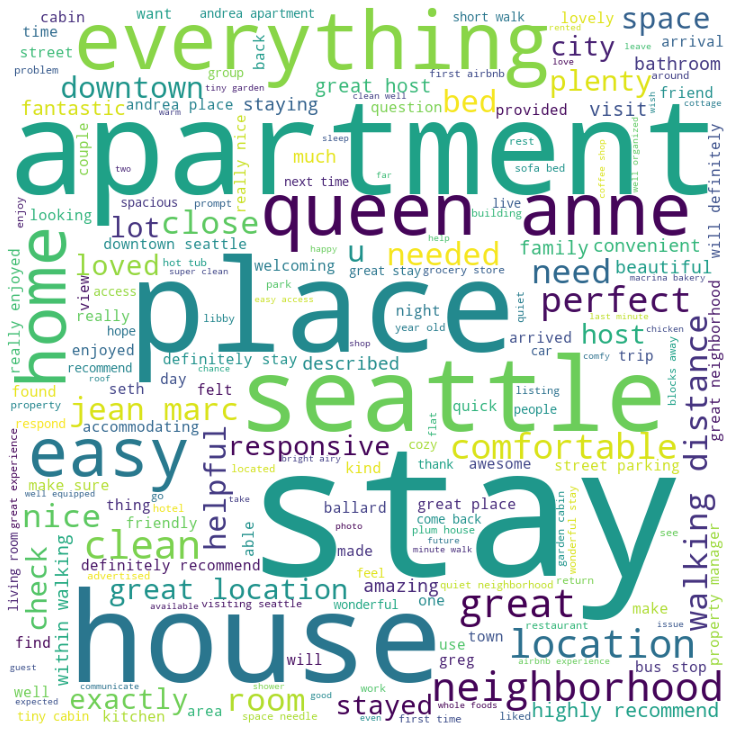

In [36]:
# Comment Clouds just to check commonly used terms on reviews

from wordcloud import WordCloud,STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)

for val in reviews_prices.comments:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                     background_color='white',
                     stopwords = stopwords,
                     min_font_size = 10).generate(comment_words)

plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [38]:
# imports
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# define function tokenize

def tokenize(text):
    '''
    for text strings to be tokenized (tokens)
    removing stop words
    Lemmatization
    '''
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/markmorelos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/markmorelos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/markmorelos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# initialize pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestRegressor())
])

# split data and remove NA values
reviews_prices.dropna(inplace=True)
X = reviews_prices['comments']
y = reviews_prices['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# pipeline fit
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_dec

In [40]:
y_preds = pipeline.predict(X_test)
y_preds

array([594.32851977, 185.75820527,  45.95234848, ..., 582.94002062,
       184.8847704 , 180.70861026])

In [48]:
mse = mean_squared_error(y_test, y_preds)
mse

9016.906182598224

In [49]:
from math import sqrt
rmse = sqrt(mse)
rmse

94.95739140582067

In [50]:
y_preds[:10]

array([594.32851977, 185.75820527,  45.95234848, 276.22154365,
        52.14207547, 183.65311249, 517.64532698, 242.59399937,
       181.32998799, 180.70861026])

In [51]:
y_test.head(10)

48013    642.0
97050    294.0
59457     43.0
67216    395.0
40095     62.0
96283    209.0
53654    610.0
49181    246.0
98317    142.0
94524    204.0
Name: price, dtype: float64

In [52]:
r2 = r2_score(y_test, y_preds)
r2

0.803118722568933

In [53]:
mae = mean_absolute_error(y_test, y_preds)
mae

47.816021168186616